In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ee
import pandas as pd
ee.Initialize()

In [2]:
# Helpers

def df_from_ee_object(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    return(df)

def array_from_df(df, variable):
    
    # get data from df as arrays
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df[variable]) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr

In [3]:
# Init params
landsat = ee.ImageCollection("LANDSAT/LC8_L1T_8DAY_NDVI")
years = [x for x in range(2013, 2016)]
area = (ee.FeatureCollection('ft:1Lhpvhw2Xea1VpyTQdKXM5K8uVcxKXT3OjCtmfXAi').filter(ee.Filter().eq('COUNTY num', 199)))

In [4]:
# # Optionally define an area by specifying a polygon
area = ee.Geometry.Polygon(
         [[[-98.51749420166016, 37.921722001139806],
           [-98.5202407836914, 37.790794553924435],
           [-98.31047058105469, 37.790794553924414],
           [-98.3060073852539, 37.92009699991215]]])

In [5]:
# import the RS products
ls = ee.ImageCollection("LANDSAT/LC8_L1T_8DAY_NDVI")

# Define time range
analysis_year = 2014

# create list for years
years = range(2013,2017);
 
# make a list with months
 
def main(year,product, area):
    # Set date in ee date format
    startdate = ee.Date.fromYMD(year,1,1)
    enddate = ee.Date.fromYMD(year+1,12,31)
    
    years = range(year, year+1)
    
    months = range(7,8)
    
    # Filter chirps
    filtered = ls.filterDate(startdate, enddate).sort('system:time_start', False).select("NDVI")

    # calculate the monthly mean
    def calcMonthlyMean(imageCollection):
        mylist = ee.List([])
        for y in years:
            for m in months:
                w = imageCollection.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).mean();
                mylist = mylist.add(w.set('year', y).set('month', m).set('date', ee.Date.fromYMD(y,m,1)).set('system:time_start',ee.Date.fromYMD(y,m,1)))
        return ee.ImageCollection.fromImages(mylist)

    # run the calcMonthlyMean function
    monthly = ee.ImageCollection(calcMonthlyMean(filtered))

    # select the region of interest, 30 is the cellsize in meters
    monthly = monthly.getRegion(area,100,"epsg:4326").getInfo()
    
    # Make it an array
    df = df_from_ee_object(monthly)
    arr = array_from_df(df, "NDVI")
    
    return arr


In [6]:
t = main(analysis_year, landsat, area)

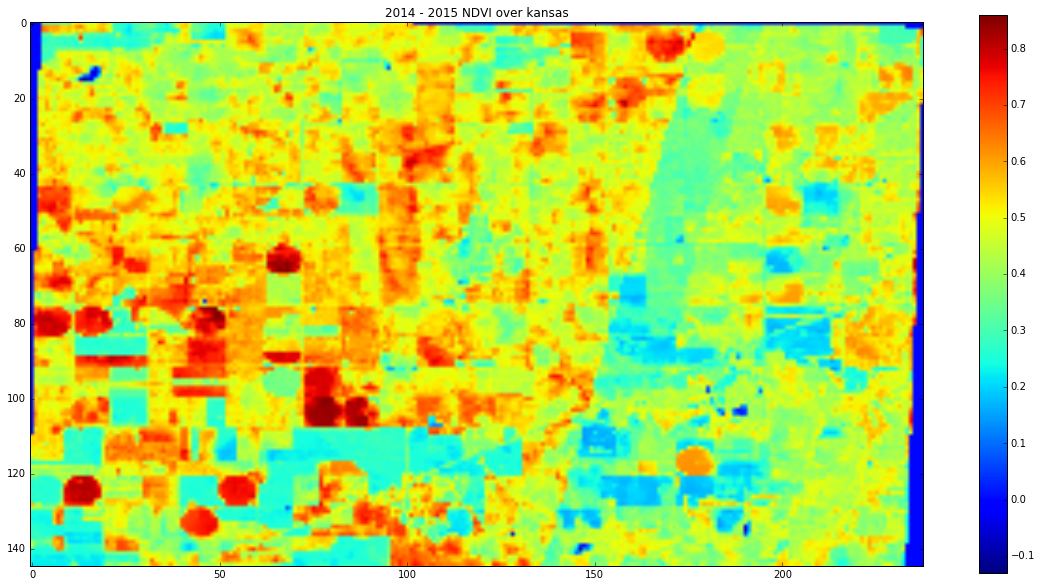

In [7]:
plt.figure(figsize=(20, 10))
plt.imshow(t)
plt.colorbar()
plt.title("{} - {} NDVI over kansas".format(str(analysis_year), str(analysis_year+1)))
plt.show()

# Kansas

In [8]:
results = []
for y in years:
    results.append(main(y,landsat, area))

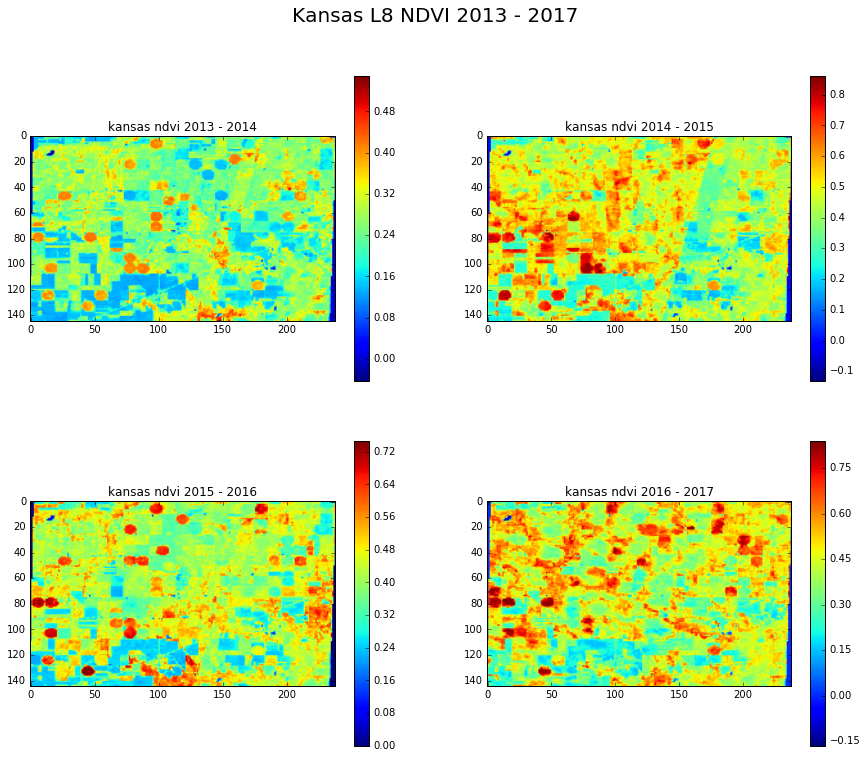

In [9]:
plt.figure(figsize=(15, 12))

plt.suptitle("Kansas L8 NDVI 2013 - 2017", size = 20)

plt.subplot(2,2,1)
plt.imshow(results[0])
plt.title("kansas ndvi 2013 - 2014")
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(results[1])
plt.title("kansas ndvi 2014 - 2015")
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(results[2])
plt.title("kansas ndvi 2015 - 2016")
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(results[3])
plt.title("kansas ndvi 2016 - 2017")
plt.colorbar()

plt.show()

# Iran

In [10]:
iran = ee.Geometry.Polygon(
        [[[38.40545654296875, 30.477082932837682],
          [38.393096923828125, 30.26618407355883],
          [38.623809814453125, 30.256694798480346],
          [38.6114501953125, 30.472348632640834]]]);

In [11]:
iran_results = []

for y in years:
    iran_results.append(main(y,landsat, iran))
    

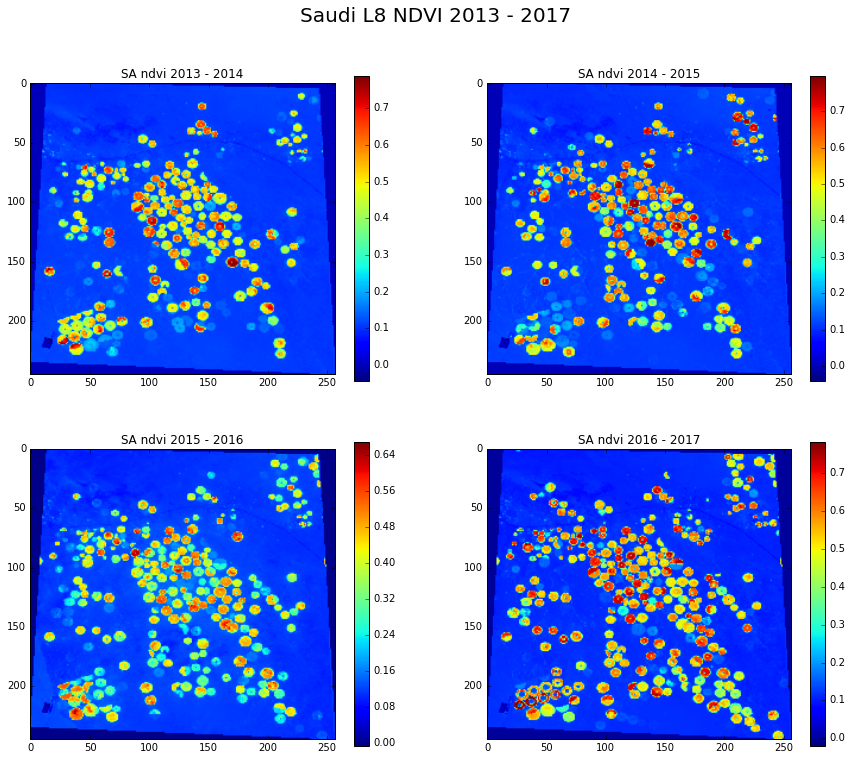

In [12]:
plt.figure(figsize=(15, 12))

plt.suptitle("Saudi L8 NDVI 2013 - 2017", size = 20)

plt.subplot(2,2,1)
plt.imshow(iran_results[0])
plt.title("SA ndvi 2013 - 2014")
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(iran_results[1])
plt.title("SA ndvi 2014 - 2015")
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(iran_results[2])
plt.title("SA ndvi 2015 - 2016")
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(iran_results[3])
plt.title("SA ndvi 2016 - 2017")
plt.colorbar()

plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import misc 
import os
import json
import cv2

In [39]:

def FindTheCircles(imgIn):

    # blur the input image
    imgIn = cv2.GaussianBlur(imgIn,(5,5),0)
    # find circles
    circles = cv2.HoughCircles(imgIn,cv2.HOUGH_GRADIENT,1,20,param1=200,param2=15,minRadius=10,maxRadius=25)

    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(imgIn,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(imgIn,(i[0],i[1]),2,(0,0,255),3)

    return circles



In [41]:
circles=FindTheCircles(f)
print('number of circles is: ' +str(len(circles[0])))

error: /Users/jenkins/miniconda/1/x64/conda-bld/conda_1486588158526/work/opencv-3.1.0/modules/imgproc/src/filter.cpp:3671: error: (-213) Unsupported combination of source format (=1), and buffer format (=5) in function getLinearRowFilter


In [33]:
t = iran_results[0]*100
f = t.astype(np.int8)

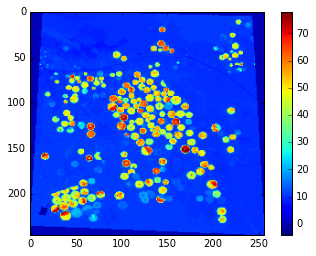

In [42]:
plt.imshow(f)
plt.colorbar()
plt.show()

In [27]:
np.max(t)

0